In [1]:
import cv2
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog


In [ ]:
def select_image(prompt):
    print(prompt)
    Tk().withdraw()  # Hide the root Tkinter window
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
    )
    if file_path:
        print(f"Selected: {file_path}")
    else:
        print("No image selected. Exiting...")
        exit()
    return file_path


In [29]:
front_image_path = select_image("Please select the FRONT image.")
back_image_path = select_image("Please select the BACK image.")


Please select the FRONT image.
Selected: C:/Users/Dell/Desktop/IMG-20250123-WA0075.jpg
Please select the BACK image.
Selected: C:/Users/Dell/Desktop/Screenshot 2025-01-24 091933.png


In [31]:
front_image = cv2.imread(front_image_path)
back_image = cv2.imread(back_image_path)

In [32]:
front_image_rgb = cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB)
back_image_rgb = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)

In [33]:
plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

(-0.5, 959.5, 1279.5, -0.5)

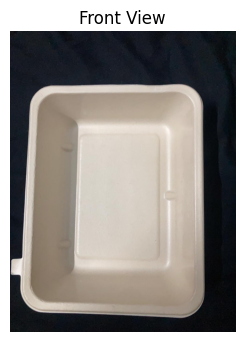

In [34]:
plt.subplot(1, 2, 1)
plt.imshow(front_image_rgb)
plt.title("Front View")
plt.axis("off")

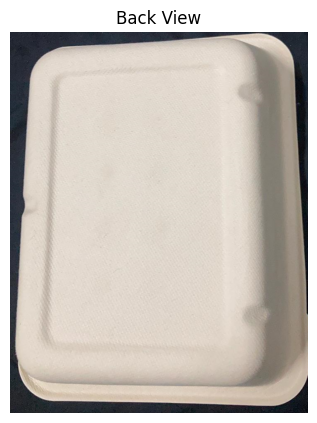

In [35]:
plt.subplot(1, 2, 2)
plt.imshow(back_image_rgb)
plt.title("Back View")
plt.axis("off")

plt.tight_layout()
plt.show()

In [36]:
def create_depth_map(front_image, back_image):
    """
    Generate a simple depth map using stereo images.
    Assumes the images are pre-aligned and cropped.
    """
    # Convert images to grayscale
    front_gray = cv2.cvtColor(front_image, cv2.COLOR_BGR2GRAY)
    back_gray = cv2.cvtColor(back_image, cv2.COLOR_BGR2GRAY)

    # Create stereo block matcher
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    
    # Compute disparity map
    disparity = stereo.compute(front_gray, back_gray)
    
    # Normalize for better visualization
    disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    
    return disparity_normalized


In [ ]:
def resize_images(front_image, back_image):
    h, w = front_image.shape[:2]  # Get the height and width of the front image
    resized_back_image = cv2.resize(back_image, (w, h))  # Resize back image to match
    return resized_back_image

def create_depth_map(front_image, back_image):
    # Convert images to grayscale
    front_gray = cv2.cvtColor(front_image, cv2.COLOR_BGR2GRAY)
    back_gray = cv2.cvtColor(back_image, cv2.COLOR_BGR2GRAY)

    # Create stereo block matcher
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    
    # Compute disparity map
    disparity = stereo.compute(front_gray, back_gray)
    
    # Normalize for better visualization
    disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    
    return disparity_normalized

def select_image(title):
    root = Tk()
    root.withdraw()  # Hide the Tkinter root window
    file_path = filedialog.askopenfilename(title=title, filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    return file_path

# Use file dialog to select front and back images
front_image_path = select_image("Select the FRONT image")
back_image_path = select_image("Select the BACK image")

# Load images using OpenCV
front_image = cv2.imread(front_image_path)
back_image = cv2.imread(back_image_path)

# Check if the images are loaded correctly
if front_image is None:
    print("Error: FRONT image not loaded. Please check the file path.")
    exit()

if back_image is None:
    print("Error: BACK image not loaded. Please check the file path.")
    exit()

# Resize back image to match front image size
back_image_resized = resize_images(front_image, back_image)

# Generate the depth map
depth_map = create_depth_map(front_image, back_image_resized)

# Display the depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.axis("off")
plt.show()


In [10]:
import numpy as np
import open3d as o3d
import cv2

def depth_map_to_3d(depth_map, camera_matrix):
    """
    Converts the depth map into 3D points.
    Arguments:
    - depth_map: A grayscale depth map image where pixel intensity corresponds to depth.
    - camera_matrix: A 3x3 intrinsic camera matrix for transforming 2D pixels to 3D coordinates.
    """
    # Get the height and width of the depth map
    h, w = depth_map.shape
    
    # Generate the 3D points (x, y, z) from the depth map
    points = []
    for y in range(h):
        for x in range(w):
            # Get the depth value (z)
            z = depth_map[y, x] / 255.0  # Normalize the depth to a [0, 1] scale
            if z > 0:  # Avoid zero depth (no data)
                # Calculate the corresponding 3D coordinates
                x3d = (x - camera_matrix[0, 2]) * z / camera_matrix[0, 0]
                y3d = (y - camera_matrix[1, 2]) * z / camera_matrix[1, 1]
                points.append([x3d, y3d, z])
    
    return np.array(points)

# Example: Camera Intrinsic Parameters (You can adjust these based on your setup)
# These parameters depend on the camera you are using
camera_matrix = np.array([[600, 0, 320],  # Focal length and principal point (cx, cy)
                          [0, 600, 240],
                          [0, 0, 1]])

# Normalize the depth map (ensure it's between 0 and 255)
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_map_normalized = np.uint8(depth_map_normalized)

# Convert the depth map to 3D points
points = depth_map_to_3d(depth_map_normalized, camera_matrix)

# Visualize the 3D points (Point Cloud)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Visualize the 3D model
o3d.visualization.draw_geometries([point_cloud])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [11]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

threshold = 0.1  
points = []

h, w = depth_map.shape
for y in range(h):
    for x in range(w):
        z = depth_map[y, x]
        if z > threshold:  
            x3d = (x - camera_matrix[0, 2]) * z / camera_matrix[0, 0]
            y3d = (y - camera_matrix[1, 2]) * z / camera_matrix[1, 1]
            points.append([x3d, y3d, z])
points = np.array(points)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

o3d.visualization.draw_geometries([point_cloud])


In [12]:
import open3d as o3d

# Assuming point_cloud is already created from Step 1

# Estimate normals of the point cloud (needed for surface reconstruction)
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Apply Poisson surface reconstruction to generate a mesh
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [13]:
# Clean the mesh by removing non-manifold edges or small connected components
mesh.remove_unreferenced_vertices()  # Remove vertices not part of the mesh
mesh = mesh.filter_smooth_simple(number_of_iterations=5)  # Smooth out the mesh

# Optionally, decimate the mesh to reduce the number of triangles for efficiency
mesh = mesh.simplify_quadric_decimation(target_number_of_triangles=10000)

# Visualize the cleaned mesh
o3d.visualization.draw_geometries([mesh])


In [14]:
# Assuming you have a texture image
texture = o3d.io.read_image("texture.jpg")
mesh.textures = [texture]

# Visualize the textured mesh
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] Read geometry::Image failed for file texture.jpg. I/O error.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [19]:
import cv2
import numpy as np
import open3d as o3d
from tkinter import Tk, filedialog

# Function to load front and back images
def load_images():
    # Use tkinter for file dialog to select images
    Tk().withdraw()
    front_image_path = filedialog.askopenfilename(title="Select the Front Image")
    back_image_path = filedialog.askopenfilename(title="Select the Back Image")

    # Load images
    front_image = cv2.imread(front_image_path)
    back_image = cv2.imread(back_image_path)

    return front_image, back_image

# Function to resize the images to the same size
def resize_images(front_image, back_image):
    # Resize back image to match front image size
    back_image_resized = cv2.resize(back_image, (front_image.shape[1], front_image.shape[0]))
    return front_image, back_image_resized

# Function to generate depth map using stereo images
def generate_depth_map(front_image, back_image):
    # Convert images to grayscale
    gray_front = cv2.cvtColor(front_image, cv2.COLOR_BGR2GRAY)
    gray_back = cv2.cvtColor(back_image, cv2.COLOR_BGR2GRAY)

    # Create stereo block matching object
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

    # Compute disparity map (this will be the depth map)
    disparity = stereo.compute(gray_front, gray_back)

    # Normalize the disparity for visualization
    disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)

    return disparity_normalized, disparity

# Function to convert depth map to point cloud
def depth_to_point_cloud(depth_map, image):
    # Intrinsic camera parameters (for example purposes)
    fx = 1000  # Focal length in x direction
    fy = 1000  # Focal length in y direction
    cx = depth_map.shape[1] / 2  # Principal point in x
    cy = depth_map.shape[0] / 2  # Principal point in y

    # Create an empty point cloud
    points = []
    colors = []

    # Convert depth map to 3D points (assuming depth_map is in millimeters)
    for v in range(depth_map.shape[0]):
        for u in range(depth_map.shape[1]):
            Z = depth_map[v, u] / 16.0  # Convert disparity to depth (mm)
            if Z == 0: continue  # Skip zero depth (invalid data)
            X = (u - cx) * Z / fx
            Y = (v - cy) * Z / fy
            points.append([X, Y, Z])

            # Add corresponding color from image
            color = image[v, u] / 255.0  # Normalize color to [0, 1]
            colors.append(color)

    # Convert points and colors to numpy arrays
    points = np.array(points)
    colors = np.array(colors)

    # Create point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud

# Load the front and back images
front_image, back_image = load_images()

# Resize images to the same size
front_image, back_image_resized = resize_images(front_image, back_image)

# Generate the depth maps
depth_map_front, _ = generate_depth_map(front_image, back_image_resized)
depth_map_back, _ = generate_depth_map(back_image_resized, front_image)

# Convert depth maps to point clouds
pcd_front = depth_to_point_cloud(depth_map_front, front_image)
pcd_back = depth_to_point_cloud(depth_map_back, back_image_resized)

# Merge the point clouds
pcd_combined = pcd_front + pcd_back

# Visualize the combined point cloud
o3d.visualization.draw_geometries([pcd_combined])

# Optionally, convert the point cloud to mesh (using Poisson surface reconstruction)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_combined, depth=9)[0]

# Visualize the 3D mesh
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


RuntimeError: [Open3D Error] (class std::tuple<class std::shared_ptr<class open3d::geometry::TriangleMesh>,class std::vector<double,class std::allocator<double> > > __cdecl open3d::geometry::TriangleMesh::CreateFromPointCloudPoisson(const class open3d::geometry::PointCloud &,unsigned __int64,float,float,bool,int)) D:\a\Open3D\Open3D\cpp\open3d\geometry\SurfaceReconstructionPoisson.cpp:731: Point cloud has no normals


In [18]:
import open3d as o3d
import cv2
import numpy as np

# Load the 3D model (mesh) that was previously reconstructed
mesh = o3d.io.read_triangle_mesh("reconstructed_model.ply")

# Load the front image to be used as the texture
front_image = cv2.imread("front_image.jpg")

# Convert the front image from BGR to RGB format (Open3D expects RGB)
front_image = cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB)

# Check if the image loaded correctly
if front_image is None:
    print("Error: Front image not found!")
else:
    print("Front image loaded successfully.")

# Convert the loaded front image to Open3D Image format
texture = o3d.geometry.Image(front_image)

# Assign the texture (front image) to the 3D model
mesh.textures = [texture]

# Print to confirm texture application
print("Texture applied to the mesh.")

# Visualize the 3D model with texture
o3d.visualization.draw_geometries([mesh], window_name="Textured 3D Model")


[Open3D WARNING] Read PLY failed: unable to open file: reconstructed_model.ply


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [24]:
import cv2
import numpy as np
import open3d as o3d
from tkinter import Tk
from tkinter.filedialog import askopenfilename

def select_file(file_type):
    """Open a file dialog to select a file."""
    Tk().withdraw()  # Don't need the root window
    file_path = askopenfilename(title=f"Select a {file_type} file", filetypes=[(f"{file_type} Files", "*.jpg;*.png;*.bmp;*.jpeg")])
    return file_path

def generate_depth_map(image):
    """Generate depth map from the front image (dummy depth map generation for demo)."""
    # For demo purposes, we simulate a simple depth map using grayscale conversion
    # You can replace this with a more complex depth map generation algorithm
    depth_map = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    depth_map = cv2.GaussianBlur(depth_map, (5, 5), 0)
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)  # Normalize depth
    return depth_map

def generate_3d_model(image_path):
    # Step 1: Load the front image
    image = cv2.imread(image_path)

    # Check if the image is loaded correctly
    if image is None:
        print("Error loading image!")
        return
    
    # Step 2: Generate depth map
    depth_map = generate_depth_map(image)

    # Step 3: Resize depth map to match the image size
    depth_map = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

    # Step 4: Generate 3D points from depth map
    points = []
    focal_length = 1000  # Adjust according to your camera's intrinsic parameters
    cx, cy = image.shape[1] // 2, image.shape[0] // 2  # Assuming center of the image is the optical center

    for v in range(image.shape[0]):
        for u in range(image.shape[1]):
            depth = depth_map[v, u] / 255.0  # Normalize depth
            if depth > 0:  # Only process valid points
                # Convert pixel coordinates to 3D world coordinates
                x = (u - cx) * depth / focal_length
                y = (v - cy) * depth / focal_length
                z = depth
                points.append([x, y, z])

    # Convert points list to numpy array
    points = np.array(points)

    # Step 5: Create a PointCloud object from the points
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Step 6: Compute normals for the point cloud
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    print("Normals computed.")

    # Step 7: Apply Poisson Surface Reconstruction to create mesh from point cloud
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

    # Step 8: Apply texture (front image) to the mesh
    front_image = cv2.imread(image_path)
    front_image = cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB)
    texture = o3d.geometry.Image(front_image)

    # Apply texture to the mesh
    mesh.textures = [texture]

    # Step 9: Visualize the final 3D model
    print("Texture applied. Visualizing 3D Model...")
    o3d.visualization.draw_geometries([mesh], window_name="Textured 3D Model")

# Main code to select the image and generate the 3D model
if __name__ == "__main__":
    print("Select front image file...")
    front_image_path = select_file("Image")
    if not front_image_path:
        print("No front image selected.")
    else:
        print(f"Front image selected: {front_image_path}")
    
    # Generate the 3D model if the image was selected
    if front_image_path:
        generate_3d_model(front_image_path)


Select front image file...
Front image selected: C:/Users/Dell/Desktop/Screenshot 2025-01-24 091835.png
Normals computed.
Texture applied. Visualizing 3D Model...
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [26]:
import cv2
import numpy as np
import open3d as o3d
from tkinter import Tk
from tkinter.filedialog import askopenfilename

def select_file(file_type):
    """Open a file dialog to select a file."""
    Tk().withdraw()  # Don't need the root window
    file_path = askopenfilename(title=f"Select a {file_type} file", filetypes=[(f"{file_type} Files", "*.jpg;*.png;*.bmp;*.jpeg")])
    return file_path

def generate_depth_map(image):
    """Generate depth map from the front image (dummy depth map generation for demo)."""
    depth_map = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    depth_map = cv2.GaussianBlur(depth_map, (5, 5), 0)
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)  # Normalize depth
    return depth_map

def highlight_defects(mesh, reference_mesh):
    """Highlight defects by comparing the reconstructed model to the reference model."""
    # Convert meshes to point clouds
    pcd = mesh.sample_points_poisson_disk(number_of_points=5000)
    reference_pcd = reference_mesh.sample_points_poisson_disk(number_of_points=5000)

    # Compute distances between the point clouds
    distances = pcd.compute_point_cloud_distance(reference_pcd)

    # Get the maximum distance for normalization purposes
    max_distance = np.max(distances)

    # Color points based on distance from the reference model
    colors = []
    for dist in distances:
        # Color defects with higher distance in red
        if dist > 0.05:  # Threshold for defect detection (can be adjusted)
            colors.append([1.0, 0.0, 0.0])  # Red color for defects
        else:
            colors.append([0.0, 1.0, 0.0])  # Green color for normal points

    # Set the colors for the points on the mesh
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def generate_3d_model(image_path, reference_model_path):
    # Step 1: Load the front image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image!")
        return

    # Step 2: Generate depth map
    depth_map = generate_depth_map(image)

    # Step 3: Resize depth map to match the image size
    depth_map = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

    # Step 4: Generate 3D points from depth map
    points = []
    focal_length = 1000
    cx, cy = image.shape[1] // 2, image.shape[0] // 2

    for v in range(image.shape[0]):
        for u in range(image.shape[1]):
            depth = depth_map[v, u] / 255.0
            if depth > 0:
                x = (u - cx) * depth / focal_length
                y = (v - cy) * depth / focal_length
                z = depth
                points.append([x, y, z])

    points = np.array(points)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Step 5: Compute normals for the point cloud
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    print("Normals computed.")

    # Step 6: Apply Poisson Surface Reconstruction to create mesh from point cloud
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

    # Step 7: Load the reference model (to compare with the generated model for defects)
    reference_mesh = o3d.io.read_triangle_mesh(reference_model_path)

    # Step 8: Highlight defects by comparing with reference model
    mesh_with_defects = highlight_defects(mesh, reference_mesh)

    # Step 9: Visualize the final 3D model with highlighted defects
    print("Defects highlighted. Visualizing 3D Model...")
    o3d.visualization.draw_geometries([mesh_with_defects], window_name="3D Model with Defects Highlighted")

# Main code to select the image and generate the 3D model
if __name__ == "__main__":
    print("Select front image file...")
    front_image_path = select_file("Image")
    reference_model_path = select_file("Reference Model")  # Choose the reference model to compare against

    if not front_image_path or not reference_model_path:
        print("No files selected.")
    else:
        print(f"Front image selected: {front_image_path}")
        print(f"Reference model selected: {reference_model_path}")
    
    # Generate the 3D model and highlight defects if the files were selected
    if front_image_path and reference_model_path:
        generate_3d_model(front_image_path, reference_model_path)


Select front image file...
Front image selected: C:/Users/Dell/Desktop/Screenshot 2025-01-24 091835.png
Reference model selected: C:/Users/Dell/Desktop/Screenshot 2025-01-24 091933.png
Normals computed.
[Open3D WARNING] Read geometry::TriangleMesh failed: unknown file extension.


RuntimeError: [Open3D Error] (class std::shared_ptr<class open3d::geometry::PointCloud> __cdecl open3d::geometry::TriangleMesh::SamplePointsPoissonDisk(unsigned __int64,double,const class std::shared_ptr<class open3d::geometry::PointCloud>,bool)) D:\a\Open3D\Open3D\cpp\open3d\geometry\TriangleMesh.cpp:541: Input mesh has no triangles.
